# Diagnosis of Heart Disease in Cleveland Patients

### Introduction:

## Methods and Results

### Exploratory Data Analysis

#### Importing Libraries

In [303]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#### Reading Data from the web 

In [304]:
# URL dataset comes from
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
# Select predictor and target variable column numbers from the description of the dataset at https://archive.ics.uci.edu/ml/datasets/Heart+Disease
heart_data <- read_delim(url, col_names=FALSE, delim=",") %>% 
    select(X1, X4, X5, X14) %>% 
# Make target variable a factor
    mutate(X14 = as_factor(X14))

# Add column names
colnames(heart_data) <- c("age", "resting_bp", "cholesterol", "disease_presence")

# Split data into training and test set with 75% of data going to the training set
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease_presence) 
heart_train <- training(heart_split) 
# for later use
heart_test <- testing(heart_split)

heart_train

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,resting_bp,cholesterol,disease_presence
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
37,130,250,0
41,130,204,0
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


#### Summary table of the number of observations in each class.

In [305]:
counts_of_disease_presence <- group_by(heart_train, disease_presence) %>%
    summarize(n=n())
counts_of_disease_presence

`summarise()` ungrouping output (override with `.groups` argument)



disease_presence,n
<fct>,<int>
0,124
1,42
2,28
3,26
4,10


#### Summary table of our predictor variables showing the min, max, and mean of each of our predictors.

In [306]:
# Select only predictor variables
predictor_vars <- heart_train %>% 
    select(-disease_presence)

# Summarize each of the metrics we are looking for using map_df
mean_summary <- predictor_vars %>% 
    map_df(mean, na.rm=TRUE)
min_summary <- predictor_vars %>% 
    map_df(min, na.rm=TRUE)
max_summary <- predictor_vars %>% 
    map_df(max, na.rm=TRUE)

# Combine predicted summary dataframes together
predictor_summary <- bind_rows(mean_summary, min_summary, max_summary)
# Combine predicted summary dataframe with descriptive row titles
predictor_summary <- bind_cols(c("mean", "min", "max"), predictor_summary)
# Rename column names to match what is in each column
colnames(predictor_summary) = c("Attribute", "age", "resting_bp", "cholesterol")

predictor_summary

New names:
* NA -> ...1



Attribute,age,resting_bp,cholesterol
<chr>,<dbl>,<dbl>,<dbl>
mean,54.04783,132.0174,247.4696
min,29.00000,100.0000,126.0000
max,77.00000,200.0000,564.0000


#### Visualizing our Training Data
Here we have created one histogram for each of our predictors showing the distribution of the values in each column.

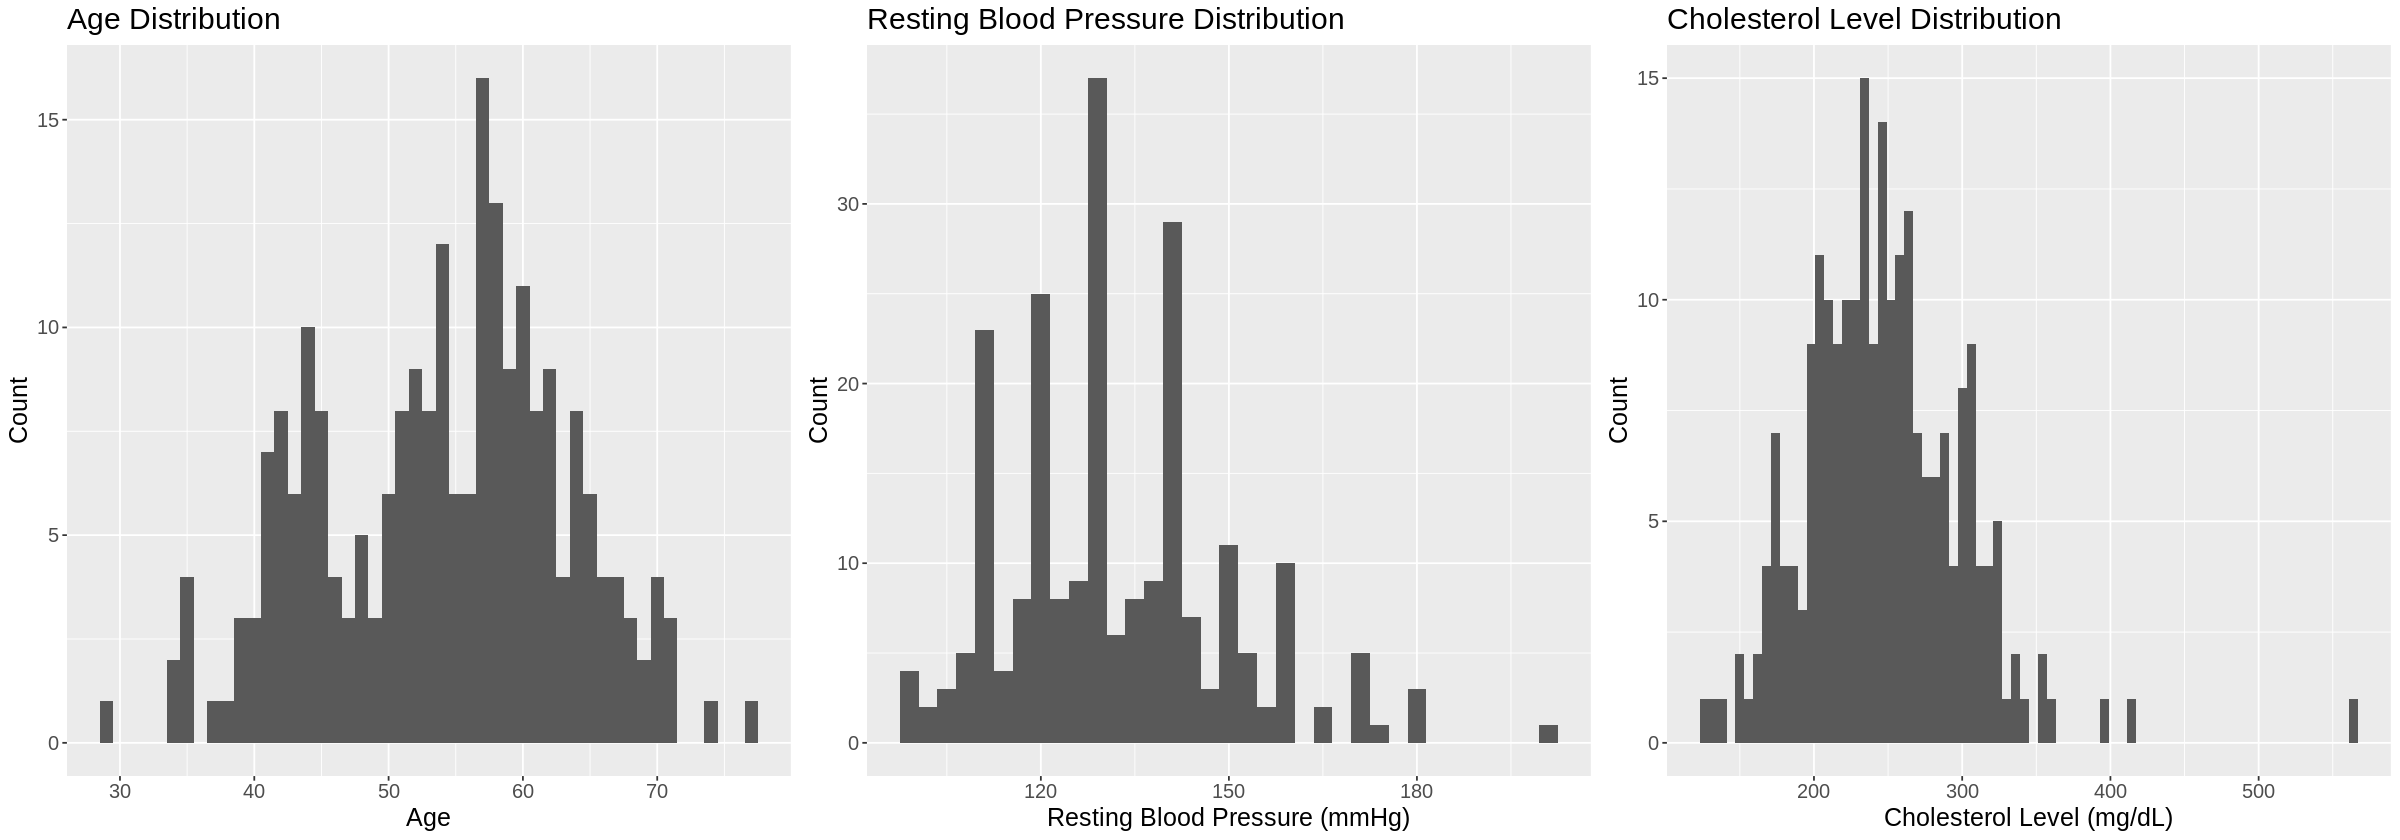

In [307]:
require(gridExtra)
options(repr.plot.height = 7, repr.plot.width = 20)
age_histogram <- ggplot(heart_train, aes(x = age)) +
    geom_histogram(binwidth = 1) +
    xlab("Age") +
    ylab("Count") +
    ggtitle("Age Distribution") +
    theme(text = element_text(size = 15))
resting_bp_histogram <- ggplot(heart_train, aes(x = resting_bp)) +
    geom_histogram(binwidth = 3) +
    xlab("Resting Blood Pressure (mmHg)") +
    ylab("Count") +
    ggtitle("Resting Blood Pressure Distribution") +
    theme(text = element_text(size = 15))
cholesterol_histogram <- ggplot(heart_train, aes(x = cholesterol)) +
    geom_histogram(binwidth = 6) +
    xlab("Cholesterol Level (mg/dL)") +
    ylab("Count") +
    ggtitle("Cholesterol Level Distribution") +
    theme(text = element_text(size = 15))

grid.arrange(age_histogram, resting_bp_histogram, cholesterol_histogram, ncol = 3)

## Data Analysis

To begin, we will create a recipe that uses all the predictors in the training set (age, resting blood pressure, and cholesterol), and scale and center the variables so that they are on a comparable magnitude. We will then create a model specification with tuning on the number of neighbors. We will then perform a 5-fold cross-validation on the training set.

In [308]:
set.seed(9999)
heart_recipe <- recipe(disease_presence ~ ., data = heart_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 5, strata = disease_presence)

We will then create a workflow analysis with our recipe and model specification and in order to have a comprehensive analysis of the best K-value, we will have it try 10 values of K. We will then collect the metrics from this workflow analysis.

In [309]:
set.seed(1234)
heart_fit <- workflow() %>%
            add_recipe(heart_recipe) %>%
            add_model(knn_spec) %>%
            tune_grid(resamples = heart_vfold, grid = 10) %>%
            collect_metrics()

We will now plot the K-value against the accuracy it yields, to visualize which value of K is the most accurate.

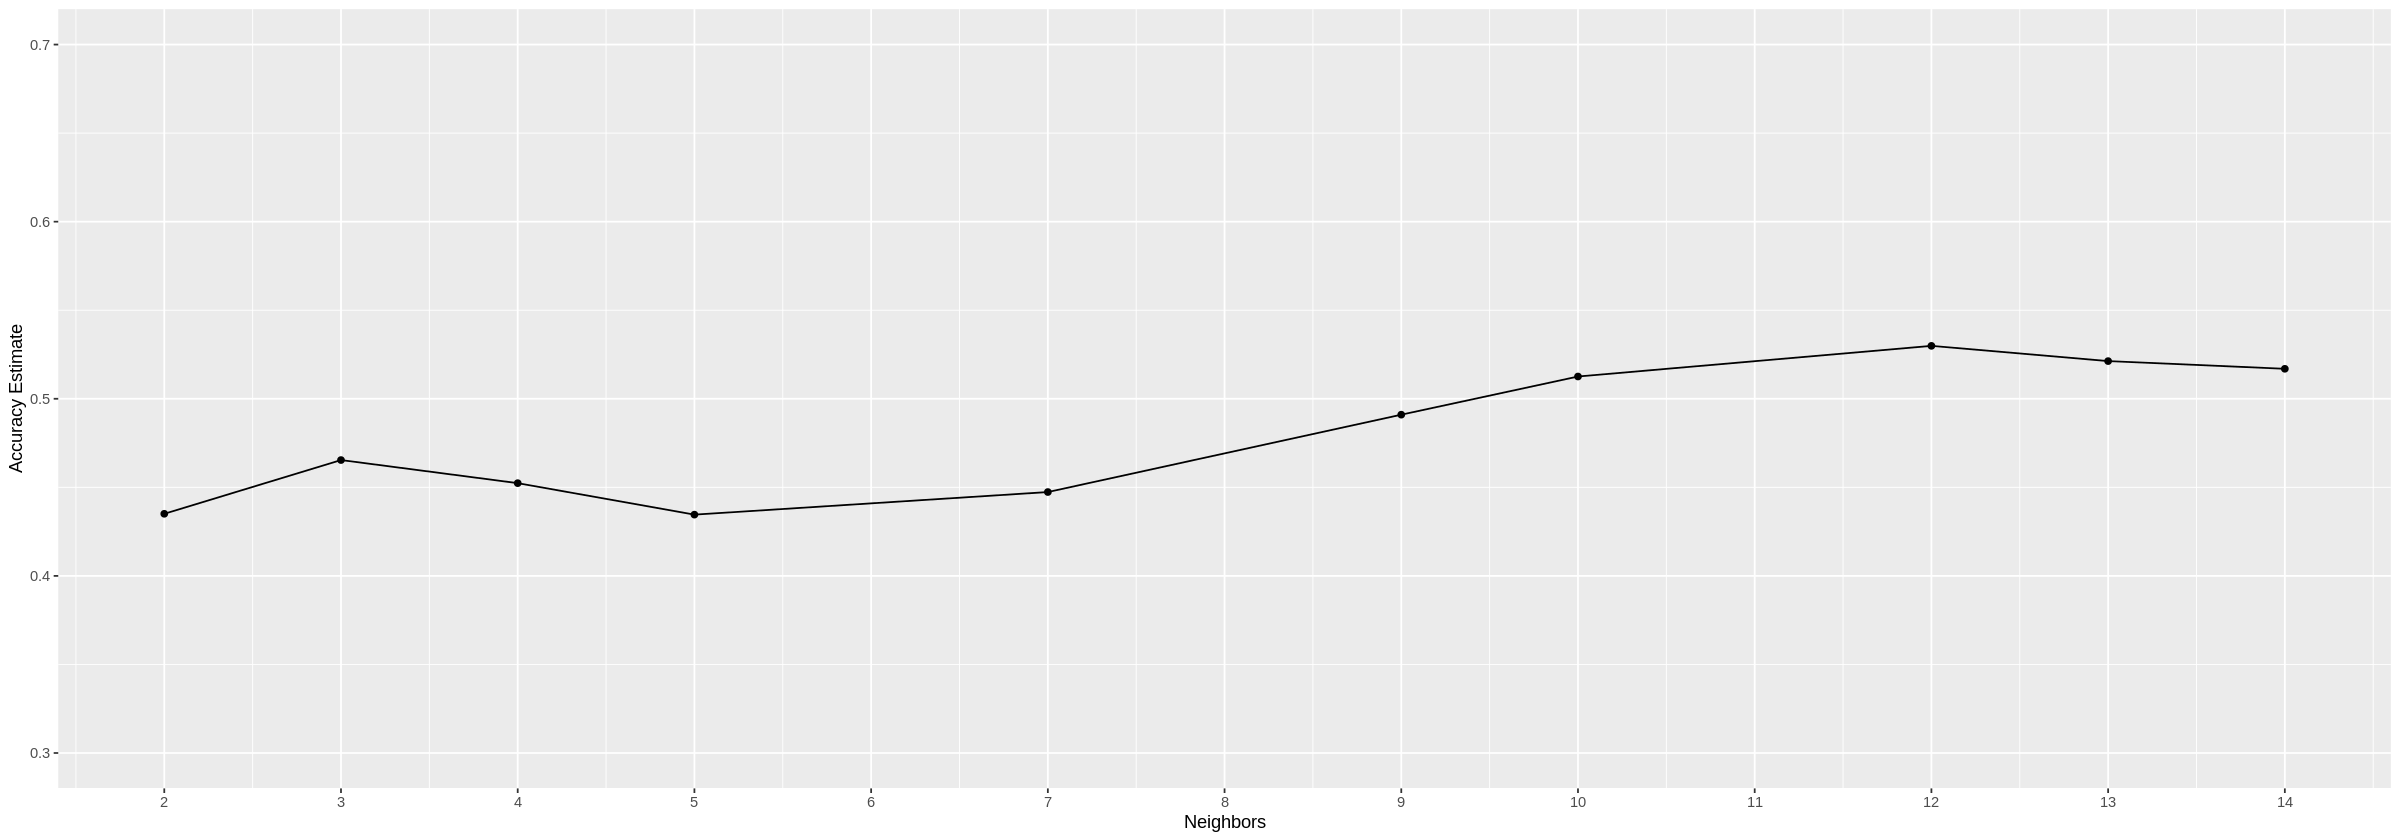

In [310]:
accuracies <- heart_fit %>% 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 15, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.3, 0.7)) # adjusting the y-axis

cross_val_plot

## Expected outcomes and significance:

### References: